In [132]:
# standard imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.datasets import make_moons

# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm

BATCHSIZE = 100
N_DIM = 2

# we define a subnet for use inside an affine coupling block
# for more detailed information see the full tutorial
def subnet_fc(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, 512), nn.ReLU(),
                         nn.Linear(512,  dims_out))

# a simple chain of operations is collected by ReversibleSequential
inn = Ff.SequenceINN(N_DIM)
for k in range(8):
    inn.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True)

optimizer = torch.optim.Adam(inn.parameters(), lr=0.001)

# a very basic training loop
for i in range(10000):
    optimizer.zero_grad()
    # sample data from the moons distribution
    data, label = make_moons(n_samples=BATCHSIZE, noise=0.00)
    x = torch.Tensor(data)
    # pass to INN and get transformed variable z and log Jacobian determinant
    z, log_jac_det = inn(x)
    # calculate the negative log-likelihood of the model with a standard normal prior
    loss = 0.5*torch.sum(z**2, 1) - log_jac_det
    loss = loss.mean() / N_DIM
    # backpropagate and update the weights
    loss.backward()
    optimizer.step()

# sample from the INN by sampling from a standard normal and transforming
# it in the reverse direction
z = torch.randn(BATCHSIZE*10, N_DIM)
samples, _ = inn(z, rev=True)

In [133]:
z = torch.randn(BATCHSIZE*10, N_DIM)
samples, _ = inn(z, rev=True)

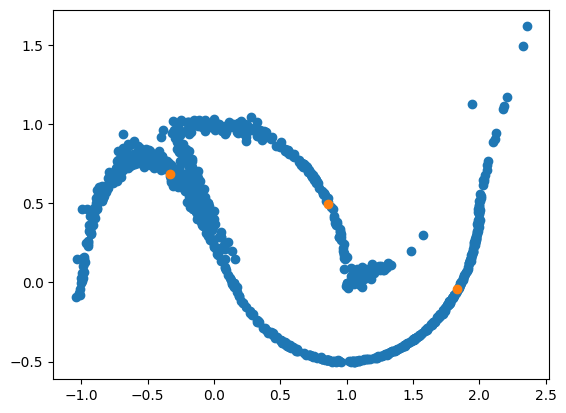

In [135]:
plt.scatter(samples[:,0].detach().cpu().numpy(), samples[:,1].detach().cpu().numpy())
# z = torch.tensor([[0,0],[-1,0],[-1,-2],[1,0],[2,0],[3,0],[-3,0]]).float()
z = torch.tensor([[i/10 - 3, 0] for i in range(60)]).float()
# z = torch.tensor([[0,i/10 - 3] for i in range(60)]).float()
z = torch.tensor([[i/10 - 2.5, -i/10 + 2.5] for i in range(60)]).float()
z = torch.tensor([[1,-0.8], [0,-1.5], [2,0]]).float()
samples2, _ = inn(z, rev=True)
plt.scatter(samples2[:,0].detach().cpu().numpy(), samples2[:,1].detach().cpu().numpy())

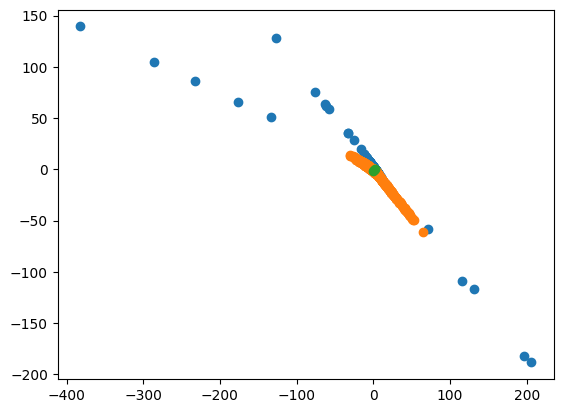

In [134]:
data = make_moons(n_samples=2000, noise=0.05, shuffle=False)[0][:1000]
samplesf, _ = inn(torch.tensor(data).float(), rev=False)
plt.scatter(samplesf[:,0].detach().cpu().numpy(), samplesf[:,1].detach().cpu().numpy())
data = make_moons(n_samples=2000, noise=0.05, shuffle=False)[0][1000:]
samplesf, _ = inn(torch.tensor(data).float(), rev=False)
plt.scatter(samplesf[:,0].detach().cpu().numpy(), samplesf[:,1].detach().cpu().numpy())
z = torch.tensor([[i/15 - 2, -i/15 + 2] for i in range(60)]).float()
z = torch.tensor([[1,-0.8], [0,-1.5], [2,0]]).float()
plt.scatter(z[:,0].detach().cpu().numpy(), z[:,1].detach().cpu().numpy())

In [64]:
from RectifiedFlow import Toy_RectifiedFlow, train_toy_rectified_flow
from models import Toy_MLP

In [114]:
data = torch.tensor(make_moons(n_samples=10000, noise=0.05, shuffle=False)[0]).float()
samplesf, _ = inn(data, rev=False)
# indeces = torch.randperm(data.shape[0])
# data = data[indeces]
pairs = torch.stack([data, samplesf], axis=1).to("cuda")
indeces = torch.randperm(pairs.shape[0])
pairs = pairs[indeces]

In [115]:
v_model = Toy_MLP(2, 8, 160)
rectflow = Toy_RectifiedFlow(v_model, "cuda")

In [116]:
optimizer = torch.optim.Adam(rectflow.v_model.parameters(),lr=5e-3)
rectflow = train_toy_rectified_flow(rectflow, optimizer, pairs, 100, 30000)

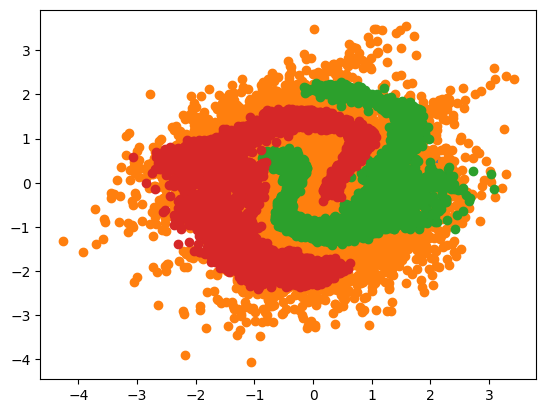

In [117]:
res = rectflow.sample_ode(data.to("cuda")[5000:], 100)[-1]
plt.scatter(data.to("cuda")[:,0].detach().cpu().numpy(), data.to("cuda")[:,1].detach().cpu().numpy())
plt.scatter(samplesf[:,0].detach().cpu().numpy(), samplesf[:,1].detach().cpu().numpy())
plt.scatter(res[:,0].detach().cpu().numpy(), res[:,1].detach().cpu().numpy())
res = rectflow.sample_ode(data.to("cuda")[:5000], 100)[-1]
plt.scatter(res[:,0].detach().cpu().numpy(), res[:,1].detach().cpu().numpy())

In [128]:
data = torch.tensor(make_moons(n_samples=10000, noise=0.05, shuffle=False)[0]).float()
samplesf, _ = inn(data, rev=False)
indeces = torch.randperm(data.shape[0])
data = data[indeces]
pairs = torch.stack([data, samplesf], axis=1).to("cuda")
indeces = torch.randperm(pairs.shape[0])
pairs = pairs[indeces]

In [129]:
v_model = Toy_MLP(2, 8, 160)
rectflow2 = Toy_RectifiedFlow(v_model, "cuda")

In [130]:
optimizer = torch.optim.Adam(rectflow2.v_model.parameters(),lr=5e-3)
rectflow2 = train_toy_rectified_flow(rectflow2, optimizer, pairs, 100, 30000)

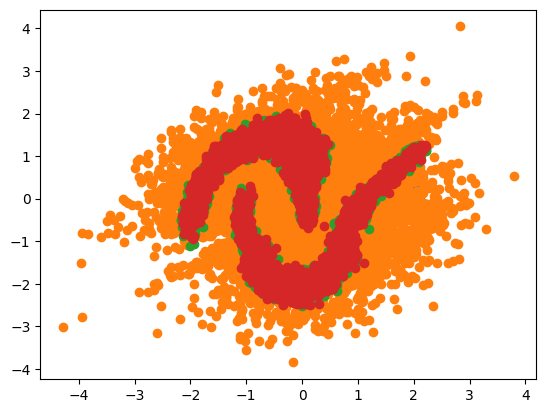

In [131]:
res = rectflow2.sample_ode(data.to("cuda")[5000:], 100)[-1]
plt.scatter(data.to("cuda")[:,0].detach().cpu().numpy(), data.to("cuda")[:,1].detach().cpu().numpy())
plt.scatter(samplesf[:,0].detach().cpu().numpy(), samplesf[:,1].detach().cpu().numpy())
plt.scatter(res[:,0].detach().cpu().numpy(), res[:,1].detach().cpu().numpy())
res = rectflow2.sample_ode(data.to("cuda")[:5000], 100)[-1]
plt.scatter(res[:,0].detach().cpu().numpy(), res[:,1].detach().cpu().numpy())